In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [39]:
Data=pd.read_csv("SBAnational.csv")

/Users/jasonsmith/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [78]:
data=Data

In [79]:
data["default"]=data.MIS_Status.apply(lambda x: 0 if x=="P I F" else 1)

#### Replace Missing Disbursement Dates with Approval Date  

In [80]:
data["DisbursementDate"]=data["DisbursementDate"].combine_first(data["ApprovalDate"])

In [81]:
data=data.drop(columns=['LoanNr_ChkDgt', 'Name', 'ChgOffDate', 'City','Bank', 'BankState', 'MIS_Status', 'Zip', 
                        'ApprovalFY','CreateJob','RetainedJob','FranchiseCode','RevLineCr','LowDoc','BalanceGross',
                       'MIS_Status','ChgOffPrinGr'])

## Weighted Coin Flip Model 

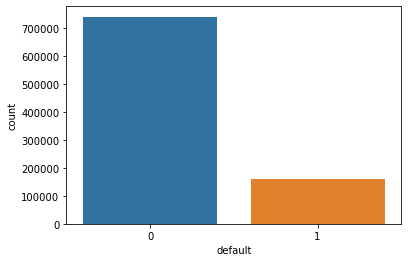

In [82]:
ax = sns.countplot(x="default", data=data)

In [83]:
print("Accuracy: "+str(len(data[data["default"]==0])/len(data)))

Accuracy: 0.8225518370397391


## Balance the Classes 

In [84]:
df0=data[data["default"]==0]
df1=data[data["default"]==1]

In [85]:
df0=df0.dropna()
df1=df1.dropna()

In [86]:
df0=df0.sample(n=159539)

In [87]:
data=pd.concat([df0, df1], ignore_index=True)

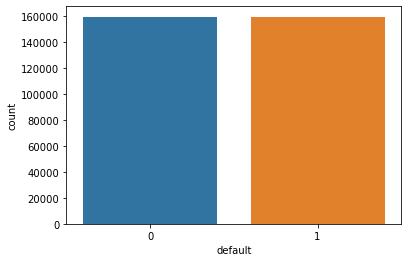

In [88]:
ax = sns.countplot(x="default", data=data)

## Feature Engineering 

#### New or Existing Busines 

In [89]:
data["new"]=data.NewExist.apply(lambda x: 1 if x==2 else 0)

#### Loans Backed by Real Estate 

In [90]:
#Create dummy var for backed by real estate or not. 1 means backed by real estate.
data["realEstate"]=data.Term.apply(lambda x: 1 if x>=240 else 0)

#### Convert Dollar Amounts from Strings to Floats 

In [91]:
def dollarsToFloat(dollarString):
    commaList=dollarString.split(",")
    stringWithDollarSign=""
    for string in commaList:
        stringWithDollarSign+=string
    return float(stringWithDollarSign.split("$")[1])

In [92]:
data["DisbursementGross"]=data.DisbursementGross.apply(lambda x: dollarsToFloat(x))

In [93]:
data["SBA_Appv"]=data.SBA_Appv.apply(lambda x: dollarsToFloat(x))

In [94]:
data["GrAppv"]=data.GrAppv.apply(lambda x: dollarsToFloat(x))

#### Portion of Loan Backed by SBA 

In [95]:
data["portion"]=data["SBA_Appv"]/data["GrAppv"]

#### Loan Approved During the 2008 Recession 

In [96]:
#Create dummy var for if loan approved during recession or not.
data["DDwithoutDay"]=data.DisbursementDate.apply(lambda x: x.split("-")[1]+x.split("-")[2])

recessionDates=set(["Dec07","Jan08","Feb08","Mar08","Apr08","May08","Jun08","Jul08","Aug08","Sep08","Oct08","Nov08","Dec08","Jan09","Feb09","Mar09","Apr09","May09","Jun09"])

data["recession"]=data.DDwithoutDay.apply(lambda x: 1 if x in recessionDates else 0)

#### Convert NAICS Codes to Industry Specification 

In [97]:
def dropLastFour(naicsCode):
    if naicsCode!=0:
        naicsString=str(naicsCode)
        return int(naicsString[0]+naicsString[1])
    else:
        return 0

In [98]:
data["IndType"]=data.NAICS.apply(lambda x: dropLastFour(x))

In [99]:
data["IndType"]=data.IndType.apply(lambda x: str(x))

#### Combine State and Industry 

In [100]:
data["stateInd"]=data["State"]+data["IndType"]

#### Urban or Rural Business 

In [101]:
data["UrbRural"]=data.UrbanRural.apply(lambda x: 1 if x==1 else 0)

In [102]:
data=data.drop(columns=["NAICS", "NewExist", "ApprovalDate", "DisbursementDate", "DDwithoutDay", "State", 
                        "stateInd","IndType"])

## Feature Selection 

In [103]:
def separationReportNumeric(columnName, xLimit, yLimit):
    print("Feature: "+columnName)
    print("default==0")
    print(data[data["default"]==0][columnName].describe())
    print("-------------")
    print("default==1")
    print(data[data["default"]==1][columnName].describe())
    print("-------------")
    fig=plt.figure(figsize=(12,10))
    ax1=fig.add_subplot(2,1,1)
    ax2=fig.add_subplot(2,1,2)
    
    ax1.set_ylim([0,yLimit])
    ax2.set_ylim([0,yLimit])
    
    ax1.set_xlim([0,xLimit])
    ax2.set_xlim([0,xLimit])

    data[data["default"]==0][columnName].hist(ax=ax1, edgecolor="black", bins=50)
    data[data["default"]==1][columnName].hist(ax=ax2, edgecolor="black", bins=50)

### A Feature With Potential for Good Separation

Feature: Term
default==0
count    159539.000000
mean        122.193282
std          79.785271
min           0.000000
25%          74.000000
50%          84.000000
75%         180.000000
max         527.000000
Name: Term, dtype: float64
-------------
default==1
count    159536.000000
mean         57.395052
std          46.503359
min           0.000000
25%          30.000000
50%          50.000000
75%          69.000000
max         461.000000
Name: Term, dtype: float64
-------------


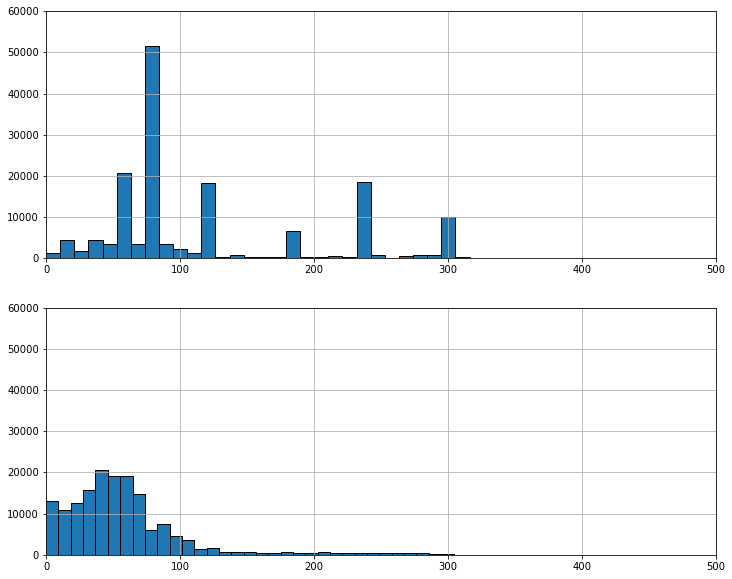

In [104]:
separationReportNumeric("Term",500,60000)

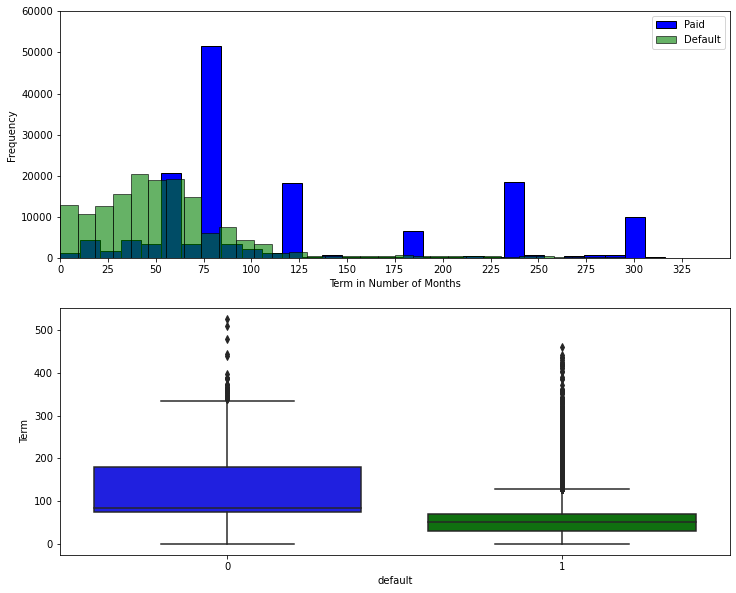

In [105]:
fig=plt.figure(figsize=(12,10))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

ax1.set_ylim([0,60000])

ax1.set_xlim([0,350])
ax1.set_xticks(np.arange(0, 350, 25))
ax1.set_xticklabels(np.arange(0, 350, 25))
ax1.set_xlabel("Term in Number of Months")

ax2.set_xlim([0,600])
ax2.set_yticks(np.arange(0, 550, 100))

data[data["default"]==0]["Term"].plot.hist(ax=ax1, edgecolor="black", bins=50, alpha=1.0, color="b", label="Paid")
data[data["default"]==1]["Term"].plot.hist(ax=ax1, edgecolor="black", bins=50, alpha=0.6, color="g", label="Default")

sns.boxplot(ax=ax2, x="default", y="Term", data=data, palette={0:"b" , 1:"g"})

ax1.legend()

## A Feature With Little Potential for Separation 

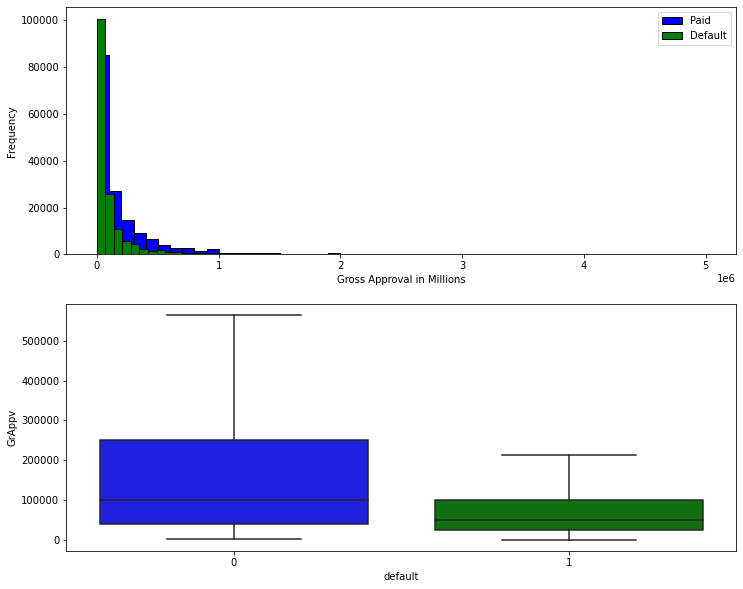

In [106]:
fig=plt.figure(figsize=(12,10))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

ax1.set_xlabel("Gross Approval in Millions")

data[data["default"]==0]["GrAppv"].plot.hist(ax=ax1, edgecolor="black", bins=50, alpha=1.0, color="b", label="Paid")
data[data["default"]==1]["GrAppv"].plot.hist(ax=ax1, edgecolor="black", bins=50, alpha=1.0, color="g", label="Default")

sns.boxplot(ax=ax2, x="default", y="GrAppv", data=data, showfliers=False , palette={0:"b" , 1:"g"})

ax1.legend()

### Colinearities

In [107]:
data_select=data[["DisbursementGross", "portion", "SBA_Appv", "GrAppv" ]]

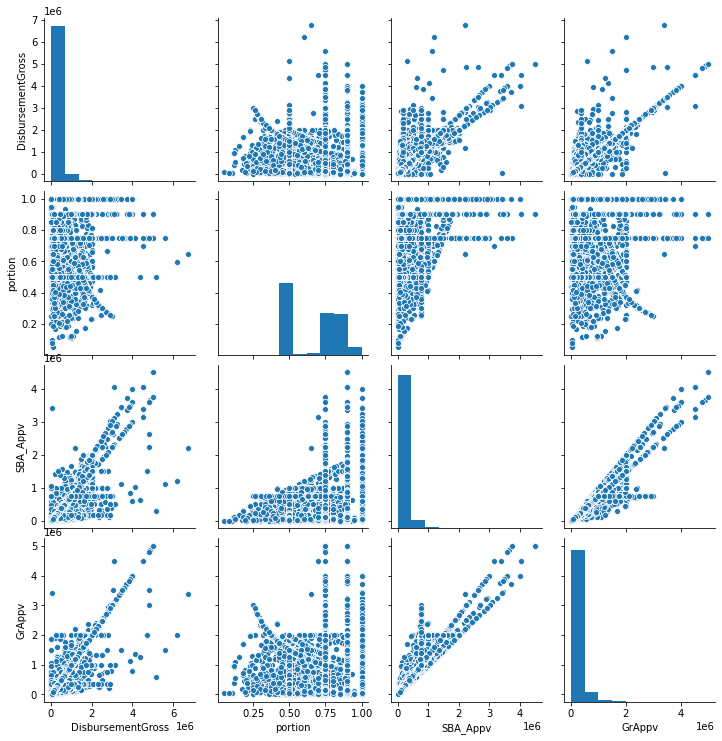

In [108]:
sns.pairplot(data_select, diag_kind='hist')

In [109]:
for column1 in list(data.columns):
    for column2 in list(data.columns):
        if column1!=column2:
            print("corr({},{})={}".format(column1, column2, data[column1].corr(data[column2])) )
            print("----------------------------------------------------------")

corr(Term,NoEmp)=0.045118326240907836
----------------------------------------------------------
corr(Term,UrbanRural)=-0.23591318822149626
----------------------------------------------------------
corr(Term,DisbursementGross)=0.4760614051086077
----------------------------------------------------------
corr(Term,GrAppv)=0.5111574832984965
----------------------------------------------------------
corr(Term,SBA_Appv)=0.5374061774113865
----------------------------------------------------------
corr(Term,default)=-0.4444569087947038
----------------------------------------------------------
corr(Term,new)=-0.03669868359814559
----------------------------------------------------------
corr(Term,realEstate)=0.8311675562068742
----------------------------------------------------------
corr(Term,portion)=0.43188857319311785
----------------------------------------------------------
corr(Term,recession)=-0.07065698548171176
----------------------------------------------------------
corr(Ter

corr(portion,DisbursementGross)=0.21311084105284214
----------------------------------------------------------
corr(portion,GrAppv)=0.2656551813264094
----------------------------------------------------------
corr(portion,SBA_Appv)=0.3529131863277991
----------------------------------------------------------
corr(portion,default)=-0.2338797347526698
----------------------------------------------------------
corr(portion,new)=0.12835431114102588
----------------------------------------------------------
corr(portion,realEstate)=0.34394156408858007
----------------------------------------------------------
corr(portion,recession)=-0.08566773323950548
----------------------------------------------------------
corr(portion,UrbRural)=-0.4044038679465616
----------------------------------------------------------
corr(recession,Term)=-0.07065698548171177
----------------------------------------------------------
corr(recession,NoEmp)=-0.012167474155132144
------------------------------------

### Scaling

In [110]:
scaler=StandardScaler()

In [111]:
scaled_cols=[ "DisbursementGross", "portion","Term", "NoEmp", "SBA_Appv", "GrAppv"] 

In [112]:
data[scaled_cols]=scaler.fit_transform(data[scaled_cols])

In [113]:
data.head()

,Term,NoEmp,UrbanRural,DisbursementGross,GrAppv,SBA_Appv,default,new,realEstate,portion,recession,UrbRural
0,-0.079490,-0.051979,2,-0.472539,-0.436164,-0.394774,0,0,0,0.964032,0,0
1,-0.408726,-0.025411,0,-0.280625,-0.243052,-0.211399,0,1,0,0.674752,0,0
2,-0.408726,-0.025411,0,-0.088712,-0.049939,-0.089149,0,0,0,0.096191,0,0
3,2.060547,-0.051979,1,0.602178,0.645266,0.607678,0,0,1,0.385471,0,1
4,-0.079490,-0.105116,1,-0.491811,-0.609966,-0.590375,0,1,0,-1.060930,0,1


### Train and Test

#### Through Guess and Check motivated by feature selection techniques and colinearities I eventually settled on the following features.

In [114]:
data1=data[['DisbursementGross', 'default', 'UrbRural',  'realEstate', 'portion', 
              'recession', 'SBA_Appv', 'GrAppv', 'Term', "NoEmp"]]

In [115]:
feature_columns=list(data1.columns)
feature_columns.remove("default")
X=data1[feature_columns]
y=data1.default

In [116]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, random_state=25)

### Decision Tree 

In [117]:
decisionTree=DecisionTreeClassifier()

In [118]:
decisionTree.fit(X_train, y_train)

DecisionTreeClassifier()

In [119]:
y_pred_DT=decisionTree.predict(X_test)

In [122]:
print("Out of the Box Decision Tree")
A=(y_pred_DT==y_test).sum()/len(y_test)
print("Accuracy: "+str(A))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_DT).ravel()
print("precision: "+str(tp/(tp+fp)))
print("recall: "+str(tp/(tp+fn)))
print("Number of leaves: "+str(decisionTree.get_n_leaves()))
print("Depth: "+str(decisionTree.get_depth()))
print("Variance: "+str(decisionTree.score(X_train,y_train)-decisionTree.score(X_test,y_test)))

Out of the Box Decision Tree
Accuracy: 0.8751896099988717
precision: 0.8795961038298741
recall: 0.8682607601308835
Number of leaves: 29218
Depth: 42
Variance: 0.11140078054712377


## Boosted Tree Ensemble Model 

#### Tuning Parameters 
+ n_estimators $=$ number of trees in the ensemble. 
+ max_depth $=$ maximum depth of trees in ensemble.
+ learning_rate $=$ "How much the weight of each each misclassified row is boosted by."  Matty Jones
    * learning rate is used to control overfitting.

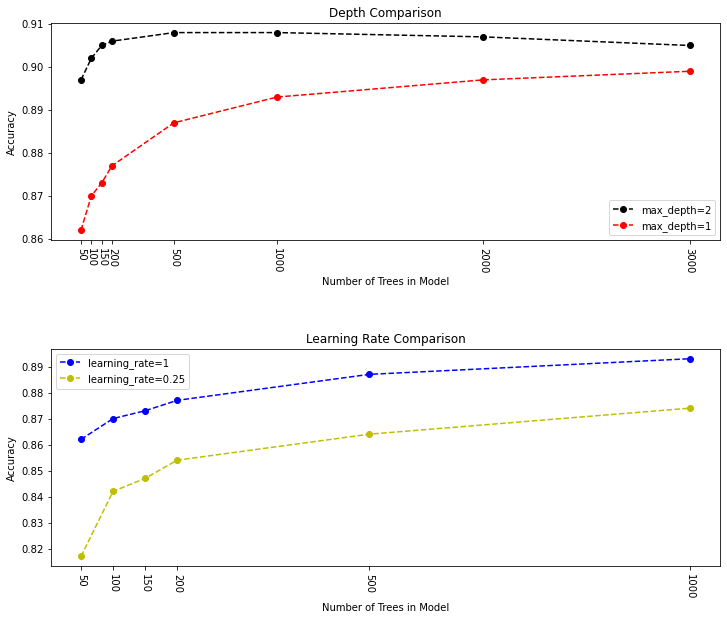

In [30]:
num_trees=[50,100,150,200,500,1000,2000,3000]
max_depth_2=[0.897,0.902,0.905,0.906,0.908,0.908,0.907,0.905] #0.905,
max_depth_1=[0.862,0.870,0.873,0.877,0.887,0.893,0.897,0.899] #,0.873

number_trees=[50,100,150,200,500,1000]
big_learn_rate=[0.862,0.870,0.873,0.877,0.887,0.893]
small_learn_rate=[0.817,0.842,0.847,0.854,0.864,0.874]

fig=plt.figure(figsize=(12,10))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

fig.subplots_adjust(hspace=.5)

ax1.plot(num_trees, max_depth_2, "ko--", label="max_depth=2")
ax1.plot(num_trees, max_depth_1, "ro--", label="max_depth=1")
ax1.set_xticks(num_trees)
ax1.set_xticklabels(num_trees, rotation=-90)
ax1.set_xlabel(xlabel="Number of Trees in Model")
ax1.set_xticklabels(num_trees, rotation=-90)
ax1.set_ylabel("Accuracy")
ax1.set_title("Depth Comparison")


ax2.plot(number_trees, big_learn_rate, "bo--", label="learning_rate=1")
ax2.plot(number_trees, small_learn_rate, "yo--", label="learning_rate=0.25")
ax2.set_xticks(number_trees)
ax2.set_xticklabels(number_trees, rotation=-90)
ax2.set_xlabel("Number of Trees in Model")
ax2.set_ylabel("Accuracy")
ax2.set_title("Learning Rate Comparison")

ax1.legend()
ax2.legend()

In [134]:
adaBoost=AdaBoostClassifier(n_estimators=1000, base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=1)

In [135]:
adaBoost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=1000)

In [136]:
y_pred_AB=adaBoost.predict(X_test)

In [137]:
print("Ada Boost, n_estimators=1000, max_depth=1, learning_rate=1")
A=(y_pred_AB==y_test).sum()/len(y_test)
print("Accuracy: "+str(A))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_AB).ravel()
print("precision: "+str(tp/(tp+fp)))
print("recall: "+str(tp/(tp+fn)))
print("Variance: "+str(adaBoost.score(X_train,y_train)-adaBoost.score(X_test,y_test)))

Ada Boost, n_estimators=1000, max_depth=1, learning_rate=1
Accuracy: 0.8948714412867154
precision: 0.8885362951209838
recall: 0.9020891014346841
Variance: -0.00012162306234986264


## Random Forest 

#### Tuning Parameters 
+ num_estimators $=$ number of trees in ensemble model 
+ max_features $=$ number of features to consider at each split

#### Out of Bag Accuracy Estimation 
+ On average each decision tree uses $2/3$ of the rows in the dataset for training.
+ Out of Bag prediction for row $i$ $=$ majority vote for the trees that do not use the row $i$ in training.
+ oob_score $=$ $\%$ of Out of Bag predictions that are correct.
+ oob_score $\approx$ Accuracy.

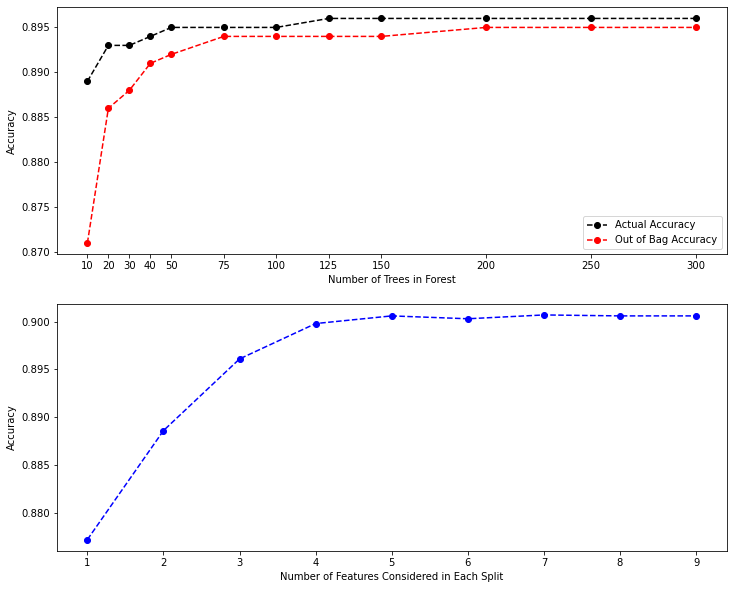

In [43]:
numTrees=[10,20,30,40,50,75,100,125,150,200,250,300]
accuracy=[0.889,0.893,0.893,0.894,0.895,0.895,0.895,0.896,0.896,0.896,0.896,0.896]

numFeatures=np.arange(1,10)
Accuracy=[0.8772,0.8886,0.8961,0.8998,0.9006,0.9003,0.9007,0.9006,0.9006]

oob=[0.871,0.886,0.888,0.891,0.892,0.894,0.894,0.894,0.894,0.895,0.895,0.895]

fig=plt.figure(figsize=(12,10))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

ax1.plot(numTrees, accuracy, "ko--", label="Actual Accuracy")
ax1.plot(numTrees, oob, "ro--", label="Out of Bag Accuracy")
ax1.set_xticks(numTrees)
ax1.set_xlabel("Number of Trees in Forest")
ax1.set_ylabel("Accuracy")

ax2.plot(numFeatures, Accuracy, "bo--")
ax2.set_xticks(np.arange(1,10))
ax2.set_xlabel("Number of Features Considered in Each Split")
ax2.set_ylabel("Accuracy")

ax1.legend()

### Seven Feature Problem 
+ Random Forests normally use max_features$=\sqrt{\text{# features}}$ in an effort to reduce variance and increase test accuracy.
+ For this model up to seven features can be used to increase the accuracy.
+ How is this possible?

In [123]:
ranForest=RandomForestClassifier(max_features=5, oob_score=True, n_estimators=125)

In [124]:
ranForest.fit(X_train, y_train)

RandomForestClassifier(max_features=5, n_estimators=125, oob_score=True)

In [125]:
y_pred_RF=ranForest.predict(X_test)

In [126]:
print("Random Forest, max_features=5, n_estimators=125")
A=(y_pred_RF==y_test).sum()/len(y_test)
print("Accuracy: "+str(A))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_RF).ravel()
print("precision: "+str(tp/(tp+fp)))
print("recall: "+str(tp/(tp+fn)))
print("Variance: "+str(ranForest.score(X_train,y_train)-ranForest.score(X_test,y_test)))

Random Forest, max_features=5, n_estimators=125
Accuracy: 0.9009514974488837
precision: 0.8964649610124312
recall: 0.9057387364711804
Variance: 0.085630535596673


### Seven Feature Problem Proposed Solution

#### Feature Importance 

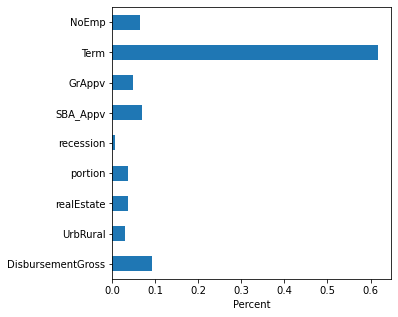

In [128]:
fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(1,1,1)

ax1.set_xlabel("Percent")

pd.Series(ranForest.feature_importances_, index=list(data1.drop(columns=["default"]).columns)).plot.barh(ax=ax1)

#### Decision Tree Only Term Feature 

In [138]:
data2=data[["Term", "default"]]

In [141]:
feature_columns=list(data2.columns)
feature_columns.remove("default")
U=data2[feature_columns]
v=data2.default

In [142]:
U_train,U_test,v_train,v_test=train_test_split(U, v, test_size=0.25, random_state=25)

In [143]:
TermDT=DecisionTreeClassifier()

In [144]:
TermDT.fit(U_train,v_train)

DecisionTreeClassifier()

In [145]:
y_pred_TDT=TermDT.predict(U_test)

In [147]:
print("Term")
A=(y_pred_TDT==y_test).sum()/len(y_test)
print("Accuracy: "+str(A))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_TDT).ravel()
print("precision: "+str(tp/(tp+fp)))
print("recall: "+str(tp/(tp+fn)))
print("Number of leaves: "+str(TermDT.get_n_leaves()))
print("Depth: "+str(TermDT.get_depth()))
print("Variance: "+str(TermDT.score(U_train,v_train)-TermDT.score(U_test,v_test)))

Term
Accuracy: 0.8904837718913362
precision: 0.901893153526971
recall: 0.8753335011326454
Number of leaves: 347
Depth: 19
Variance: -4.636391181644939e-06


## Pruned Decision Tree 

### Cost Complexity Pruning
Given a decision tree $T_0$ and a subtree $T$ of $T_0$ define:
+ $R(T)=$ misclassification error for $T$.  (misclassification error $=1-$ accuracy)
+ $\mathcal{L}(T)=$ number of leaves of $T$.
+ $\alpha=$ tuning parameter.  $\alpha$ is usually less than $0.1$.

Goal: Minimize $R(T)+\alpha \cdot \mathcal{L}(T)$

In [148]:
prunedDT=DecisionTreeClassifier(ccp_alpha=0.000025)

In [149]:
prunedDT.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=2.5e-05)

In [150]:
y_pred_prunedDT=prunedDT.predict(X_test)

In [160]:
print("ccp_alpha=0.000025")
A=(y_pred_prunedDT==y_test).sum()/len(y_test)
print("Accuracy: "+str(A))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_prunedDT).ravel()
print("precision: "+str(tp/(tp+fp)))
print("recall: "+str(tp/(tp+fn)))
print("Number of leaves: "+str(prunedDT.get_n_leaves()))
print("Depth: "+str(prunedDT.get_depth()))
print("Variance: "+str(prunedDT.score(X_train,y_train)-prunedDT.score(X_test,y_test)))

ccp_alpha=0.000025
Accuracy: 0.9092253883087414
precision: 0.9093979182943118
recall: 0.9082305562547194
Number of leaves: 374
Depth: 16
Variance: 0.0032506883462525282


## Classifier Results 

In [159]:
pd.DataFrame({"Classifier": ["Decision Tree", "Boosted Ensemble", "Random Forest", "Pruned Decision Tree"],
                        "Accuracy":[0.88,0.89, 0.90, 0.91],
                        "Precision":[0.88,0.88,0.90,0.91],
                        "Recall":[0.87,0.89,0.90,0.91],
                        "Variance":[0.11, 0.0, 0.0, 0.09],
                         "Num Leaves": [29218, "NA", "NA", 374]})


,Classifier,Accuracy,Precision,Recall,Variance,Num Leaves
0,Decision Tree,0.88,0.88,0.87,0.11,29218
1,Boosted Ensemble,0.89,0.88,0.89,0.00,NA
2,Random Forest,0.90,0.90,0.90,0.00,NA
3,Pruned Decision Tree,0.91,0.91,0.91,0.09,374


## SVD reduction 

In [112]:
feature_columns=list(data1.columns)
feature_columns.remove("default")
X=data1[feature_columns]
y=data1.default

In [220]:
SVD=TruncatedSVD(n_components=7)

In [221]:
X_reduced=SVD.fit_transform(X) # X is dim reduced X 

In [222]:
X_reduced_train,X_reduced_test,y_train,y_test=train_test_split(X_reduced, y, test_size=0.25, random_state=25)

In [223]:
randomForest=RandomForestClassifier(n_estimators=125, max_features=7)

In [224]:
randomForest.fit(X_reduced_train, y_train)

RandomForestClassifier(max_features=7, n_estimators=125)

In [225]:
y_pred=randomForest.predict(X_reduced_test)

### Collect data on SVD reduction 

In [205]:
print("number of columns: 6, max features: 3, number of trees: 125")
A=(y_pred==y_test).sum()/len(y_test)
print("Accuracy: "+str(A))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("precision: "+str(tp/(tp+fp)))
print("recall: "+str(tp/(tp+fn)))
print("--confusion matrix--")
print(confusion_matrix(y_test, y_pred).transpose())

number of columns: 6, max features: 3, number of trees: 125
Accuracy: 0.8753275081798694
precision: 0.8765391519809865
recall: 0.8725899823810722
--confusion matrix--
[[35156  5062]
 [ 4883 34668]]
